In [1]:
import pandas as pd 
import numpy as np
df=pd.read_csv("MUMBAI.csv")

/var/folders/kt/q0sjjgn94nz3_lf77pxkgr6h0000gn/T/ipykernel_3035/2495537555.py:3: DtypeWarning: Columns (12,18,19,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("MUMBAI.csv")


In [2]:
# === Core Python & System ===
import os
import random
from datetime import datetime

# === Data Manipulation ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt

# === Scikit-learn ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === TensorFlow / Keras ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [3]:

df=df.iloc[:,:-2]
df=df.apply(pd.to_numeric,errors='coerce')

# As avg wind speed is missing for 21126 columns 
df[['AW','FFF']].corr()
# So correlation is moderate and 75% of AW data is missing let's drop it.
df.drop(["AW"], axis=1,inplace=True)

df["HR"]=df["HR"]/4

# List of categorical columns to fill by month-wise mode
cat_cols_by_month = ['DD', 'Cm', 'A.1', 'Dl', 'Dm', 'TC', 'h', 'c', 'Ht']

# Filling each categorical column's null values using the mode of its month
for col in cat_cols_by_month:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill high-null categorical columns with month-wise mode or 'Unknown'
for col in ['Ch', 'A.2', 'Dh']:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill numeric columns with median of the respective month
for col in ['VP', 'FFF', 'VV']:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.median()))

# Fill 'DD' with mode of respective month
df['DD'] = df.groupby('MN')['DD'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill missing values with month-wise median
df['RF'] = df.groupby('MN')['RF'].transform(lambda x: x.fillna(x.median()))
# Fill by daily median first , Beacuse it may vary day to day a lot.
df['EVP'] = df.groupby(['YEAR', 'MN', 'DT'])['EVP'].transform(lambda x: x.fillna(x.median()))

# Removing INDEX and setime datetime as new Index
df=df.drop('INDEX',axis=1)
df['datetime']=pd.to_datetime(df[['YEAR','MN','DT','HR']].rename(columns={
    'YEAR':'year',
    'MN':'month',
    'DT':'day',
    'HR':'hour'
}),errors='coerce')

df.index = pd.to_datetime(df.index)
df = df[df['datetime'].dt.year != 2020]
df.set_index('datetime',inplace=True)

In [4]:
# As month,day and time don't affect fff much so drop them
df.drop(['YEAR','MN','DT','HR'],axis=1,inplace=True)

# Sorting the dataframe by timestamp
df = df.sort_values('datetime')

In [5]:
# Outlier Detection
from scipy.stats import zscore
import numpy as np

# Step 1: Select numeric columns only
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Compute Z-scores for each numeric column
z_scores = np.abs(zscore(df[numeric_cols]))

# Step 3: Define a threshold and filter out outliers
threshold = 3
df = df[(z_scores < threshold).all(axis=1)]

FFF     1.000000
DD      0.805569
DBT     0.503113
WBT     0.371896
A       0.288358
Cl      0.278726
TC      0.277204
Dl      0.254787
c       0.251594
Ht      0.251594
VP      0.236208
VV      0.221812
DPT     0.216186
RF      0.208417
Dm      0.188280
Cm      0.178491
A.1     0.149542
A.2     0.001219
Ch     -0.001513
Dh     -0.004911
RH     -0.233898
EVP    -0.237352
h      -0.265520
a      -0.266727
SLP    -0.364263
MSLP   -0.366972
Name: FFF, dtype: float64


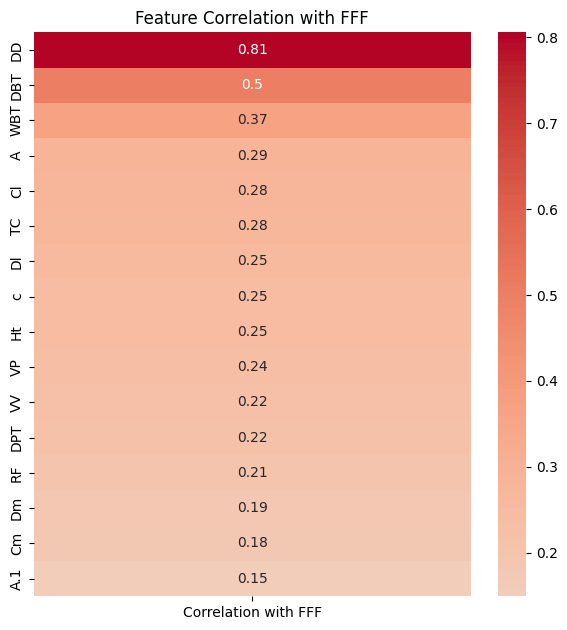

In [6]:
correlation_with_fff = df.corr()['FFF'].sort_values(ascending=False)
print(correlation_with_fff)


features = [
     'DD', 'DBT', 'WBT', 'A', 'Cl', 'TC', 'Dl', 'c', 'Ht',
     'VP', 'VV'
    , 'DPT',  'RF', 'Dm', 'Cm', 'A.1'
]

import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation of each feature with FFF
correlation_with_fff = df[features + ['FFF']].corr()['FFF'].drop('FFF')

# Convert to DataFrame for heatmap
corr_df = correlation_with_fff.to_frame(name='Correlation with FFF')

# Plot heatmap
plt.figure(figsize=(6, len(corr_df) * 0.4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with FFF')
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
df['VP_log'] = np.log1p(df['VP'])      
df['RF_sqrt'] = np.sqrt(df['RF'])       # for skewed rainfall

df['temp_diff'] = df['DBT'] - df['WBT']     # humidity proxy
df['humid_ratio'] = df['VP'] / (df['DBT'] + 0.1)
df['wind_humidity'] = df['RH'] * df['VV']

df['VV_squared'] = df['VV'] ** 2
df['DPT_squared'] = df['DPT'] ** 2

df['VP_roll3'] = df['VP'].rolling(window=3).mean()
df['RF_lag1'] = df['RF'].shift(1)

from scipy.stats.mstats import winsorize

df['RF_winz'] = winsorize(df['RF'], limits=[0.01, 0.01])

df['month'] = df.index.month
df['season'] = df['month'] % 12 // 3 + 1  # Season: 1=spring, ..., 4=winter

# Cyclic encode ==>> As months are in a cycle 1->12->1
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# (Optional) Drop original month column
df.drop('month', axis=1, inplace=True)

# One hot encoding ==>> COnverting categorical into Binary data
season_dummies = pd.get_dummies(df['season'], prefix='season')
df = pd.concat([df, season_dummies], axis=1)
df.drop('season', axis=1, inplace=True)

df.dropna(axis=0,inplace=True)
df.isnull().sum()
df.dtypes

SLP              float64
MSLP             float64
DBT              float64
WBT              float64
DPT              float64
RH                 int64
VP               float64
DD               float64
FFF              float64
VV               float64
Cl                 int64
A                  int64
Cm               float64
A.1              float64
Ch               float64
A.2              float64
Dl               float64
Dm               float64
Dh               float64
TC               float64
h                float64
c                float64
a                  int64
Ht               float64
RF               float64
EVP              float64
VP_log           float64
RF_sqrt          float64
temp_diff        float64
humid_ratio      float64
wind_humidity    float64
VV_squared       float64
DPT_squared      float64
VP_roll3         float64
RF_lag1          float64
RF_winz          float64
month_sin        float64
month_cos        float64
season_1            bool
season_2            bool


FFF              1.000000
DD               0.805563
DBT              0.503082
WBT              0.371856
season_3         0.318829
A                0.288327
Cl               0.278701
TC               0.277176
temp_diff        0.268573
Dl               0.254756
Ht               0.251561
c                0.251561
VP               0.236170
DPT_squared      0.235686
VP_roll3         0.235277
RF_sqrt          0.224903
VV_squared       0.221806
VV               0.221806
DPT              0.216145
RF_lag1          0.214820
VP_log           0.214292
RF_winz          0.211845
RF               0.208381
Dm               0.188260
Cm               0.178474
A.1              0.149546
season_2         0.034374
A.2              0.001219
Ch              -0.001514
Dh              -0.004912
month_sin       -0.047058
humid_ratio     -0.065695
season_1        -0.178314
season_4        -0.193495
wind_humidity   -0.232113
RH              -0.233935
EVP             -0.237316
h               -0.265488
a           

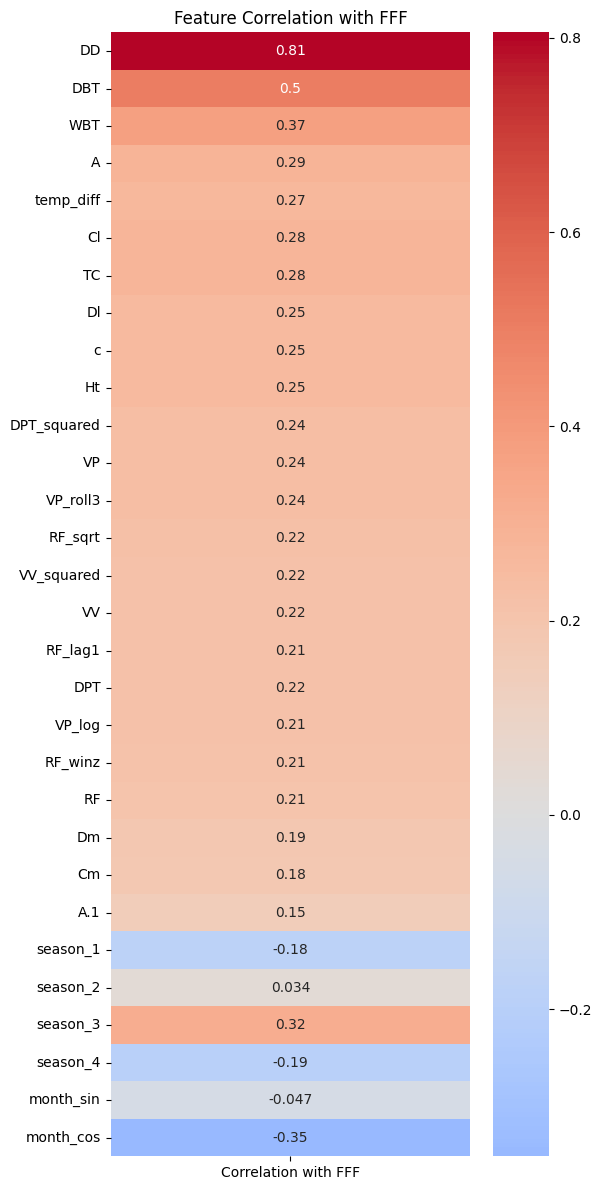

In [8]:
correlation_with_fff = df.corr()['FFF'].sort_values(ascending=False)
print(correlation_with_fff)


import seaborn as sns
import matplotlib.pyplot as plt

features = [
     'DD', 'DBT', 'WBT', 'A', 'temp_diff', 'Cl', 'TC', 'Dl', 'c', 'Ht',
    'DPT_squared', 'VP', 'VP_roll3', 'RF_sqrt', 'VV_squared', 'VV',
    'RF_lag1', 'DPT', 'VP_log', 'RF_winz', 'RF', 'Dm', 'Cm', 'A.1','season_1','season_2','season_3','season_4','month_sin','month_cos'
]

# Compute correlation of each feature with FFF
correlation_with_fff = df[features + ['FFF']].corr()['FFF'].drop('FFF')

# Convert to DataFrame for heatmap
corr_df = correlation_with_fff.to_frame(name='Correlation with FFF')

# Plot heatmap
plt.figure(figsize=(6, len(corr_df) * 0.4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with FFF')
plt.tight_layout()
plt.show()


In [9]:
# Feature columns (you can fine-tune this list)
features = [
     'DD', 'DBT', 'WBT', 'A', 'temp_diff', 'Cl', 'TC', 'Dl', 'c', 'Ht',
    'DPT_squared', 'VP', 'VP_roll3', 'RF_sqrt', 'VV_squared', 'VV',
    'RF_lag1', 'DPT', 'VP_log', 'RF_winz', 'RF', 'Dm', 'Cm', 'A.1','season_1','season_2','season_3','season_4','month_sin','month_cos'
]
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# X = your features, y = your target (e.g. FFF)
X = df[features]  # your selected columns
Y = df['FFF']

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

DD             0.772277
VP_roll3       0.045990
temp_diff      0.026797
DBT            0.025460
WBT            0.013895
season_3       0.012982
VP_log         0.008638
VP             0.008501
RF_lag1        0.008400
month_cos      0.008382
DPT_squared    0.008250
TC             0.008248
DPT            0.007986
month_sin      0.007818
A              0.005571
Cl             0.004424
A.1            0.004071
season_2       0.003314
VV             0.002629
VV_squared     0.002608
RF             0.002600
RF_sqrt        0.002541
RF_winz        0.002368
Cm             0.002046
Ht             0.001233
c              0.001162
Dm             0.000799
season_4       0.000470
season_1       0.000295
Dl             0.000242
dtype: float64


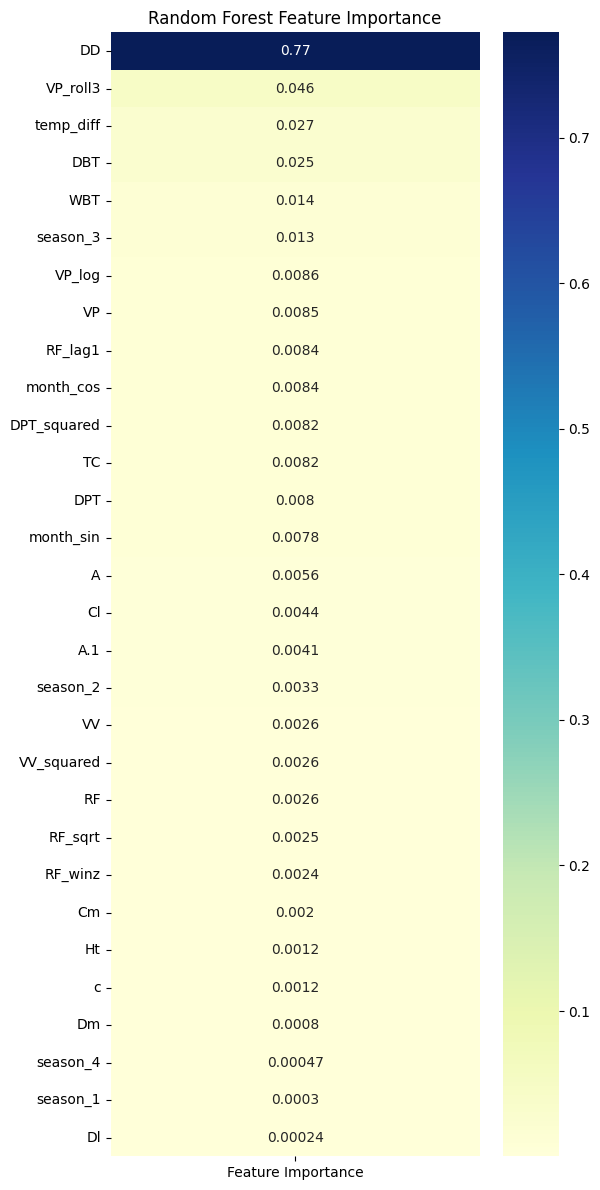

In [10]:
# Convert to DataFrame for heatmap
importance_df = importances.to_frame(name='Feature Importance')

# Plot heatmap
plt.figure(figsize=(6, len(importance_df) * 0.4))
sns.heatmap(importance_df, annot=True, cmap='YlGnBu')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

In [11]:
# WE WILL KEEP FEATURES OF importance ≥ 0.005 AND |correlation| ≥ 0.15
# SO NOW WILL SPLIT FEATURES INTO 2 GROUPS
primary_features=['DD', 'DBT', 'WBT', 'DPT', 'DPT_squared', 'VP_log', 'VP_roll3', 'RF_lag1',
 'VP', 'temp_diff', 'TC', 'A', 'Cl','season_3','month_sin','month_cos']
# Will try with these also and check is model performing more better or not.
secondary_features=['Dl','Ht', 'c', 'VV', 'Dm', 'Cm','season_2']

In [12]:
# Using BiLSTM
# Reshape input for BiLSTM
import numpy as np
from sklearn.model_selection import train_test_split

# X = your selected primary features
# Y = target variable (FFF)

X = df[primary_features].values
Y = df['FFF'].values


# Ensure numeric types
X = df[primary_features].apply(pd.to_numeric, errors='coerce').values
Y = pd.to_numeric(df['FFF'], errors='coerce').values

def create_lookback_sequences(X, Y, lookback):
    Xs, Ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback:i])
        Ys.append(Y[i])
    return np.array(Xs), np.array(Ys)

lookback = 24  # will come from GWO population

# X_combined, Y_combined = create_lookback_sequences(X, Y, lookback)
X_seq, Y_seq = create_lookback_sequences(X, Y, lookback)

# Split after generating sequences
X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)
input_shape = (X_train.shape[1], X_train.shape[2])

In [13]:
# Define BiLSTM model architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# === Define BiLSTM model ===
def create_bilstm_model(input_shape, units=64, dropout_rate=0.2, num_layers=1, learning_rate=1e-3):
    model = Sequential()
    for i in range(num_layers):
        return_seq = (i != num_layers - 1)
        model.add(Bidirectional(LSTM(units, return_sequences=return_seq), input_shape=input_shape if i == 0 else None))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [14]:
import random
# === GA search space ===
search_space = {
    'units': [32, 64, 96, 128],
    'dropout': [0.1, 0.2, 0.3, 0.4],
    'batch_size': [16, 32, 48, 64],
    'num_layers': [1, 2, 3],
    'lookback': [12, 24, 48],
    'learning_rate': [1e-2, 1e-3, 1e-4]
}

# Objective function for GA: returns MSE on validation set
def evaluate_individual(params):
    units, dropout, batch_size, num_layers, lookback, learning_rate = params
    try:
        X = df[primary_features].apply(pd.to_numeric, errors='coerce').astype(float).values
        Y = pd.to_numeric(df['FFF'], errors='coerce').astype(float).values
        X_seq, Y_seq = create_lookback_sequences(X, Y, lookback)
        X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)
        model = create_bilstm_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                     units=units, dropout_rate=dropout,
                                     num_layers=num_layers, learning_rate=learning_rate)
        model.fit(X_train, Y_train, epochs=5, batch_size=batch_size, verbose=0, validation_split=0.1)
        preds = model.predict(X_test)
        mse = mean_squared_error(Y_test, preds)
        return mse
    except Exception as e:
        print(f"Error: {e}")
        return float('inf')


In [15]:
# === GA methods ===
def generate_individual():
    return [
        random.choice(search_space['units']),
        random.choice(search_space['dropout']),
        random.choice(search_space['batch_size']),
        random.choice(search_space['num_layers']),
        random.choice(search_space['lookback']),
        random.choice(search_space['learning_rate'])
    ]

def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual, mutation_rate=0.3):
    if random.random() < mutation_rate:
        idx = random.randint(0, len(individual) - 1)
        keys = list(search_space.keys())
        individual[idx] = random.choice(search_space[keys[idx]])
    return individual

# === GA loop ===
population_size = 6
generations = 5
top_k = 2
population = [generate_individual() for _ in range(population_size)]
best_mse = float('inf')
best_params = None

best_mse_per_generation = []

for gen in range(generations):
    print(f"\nGeneration {gen+1}/{generations}")
    scored_population = []
    for ind in population:
        mse = evaluate_individual(ind)
        scored_population.append((mse, ind))
        print(f"Params: {ind}, MSE: {mse:.4f}")

    scored_population.sort(key=lambda x: x[0])
    population = [ind for _, ind in scored_population[:top_k]]

    best_mse_per_generation.append(scored_population[0][0])
    
    if scored_population[0][0] < best_mse:
        best_mse = scored_population[0][0]
        best_params = scored_population[0][1]

    new_population = population.copy()
    while len(new_population) < population_size:
        p1, p2 = random.sample(population, 2)
        c1, c2 = crossover(p1, p2)
        new_population.extend([mutate(c1), mutate(c2)])
    population = new_population[:population_size]

print("\nBest Params:", best_params)
print("Best MSE:", best_mse)


Generation 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.9914


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Params: [64, 0.4, 32, 3, 12, 0.001], MSE: 20.0887


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Params: [32, 0.3, 16, 1, 48, 0.001], MSE: 23.9708


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Params: [96, 0.4, 16, 1, 12, 0.0001], MSE: 23.4418


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Params: [96, 0.3, 32, 3, 12, 0.001], MSE: 20.1516


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Params: [96, 0.1, 32, 1, 48, 0.01], MSE: 31.8820

Generation 2/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.0520


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Params: [64, 0.4, 32, 3, 12, 0.001], MSE: 20.3109


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Params: [96, 0.2, 32, 3, 12, 0.001], MSE: 19.6984


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Params: [64, 0.4, 48, 2, 12, 0.001], MSE: 20.8684


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Params: [96, 0.2, 48, 3, 12, 0.001], MSE: 19.1626


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Params: [64, 0.4, 32, 2, 12, 0.001], MSE: 19.8886

Generation 3/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.0734


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Params: [96, 0.2, 48, 3, 12, 0.001], MSE: 19.6488


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.7540


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.2446


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Params: [96, 0.2, 64, 3, 12, 0.001], MSE: 18.9598


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.9810

Generation 4/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Params: [96, 0.2, 64, 3, 12, 0.001], MSE: 20.1975


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.4690


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Params: [96, 0.2, 64, 2, 12, 0.001], MSE: 20.0823


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Params: [96, 0.2, 48, 3, 12, 0.001], MSE: 18.9994


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Params: [96, 0.2, 64, 3, 12, 0.001], MSE: 19.6780


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.4419

Generation 5/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Params: [96, 0.2, 48, 3, 12, 0.001], MSE: 19.5357


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.2868


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Params: [96, 0.4, 48, 3, 12, 0.001], MSE: 19.7397


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.8852


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Params: [96, 0.2, 48, 2, 12, 0.001], MSE: 19.3233


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Params: [96, 0.2, 64, 3, 12, 0.001], MSE: 19.5470

Best Params: [96, 0.2, 64, 3, 12, 0.001]
Best MSE: 18.95976853726533


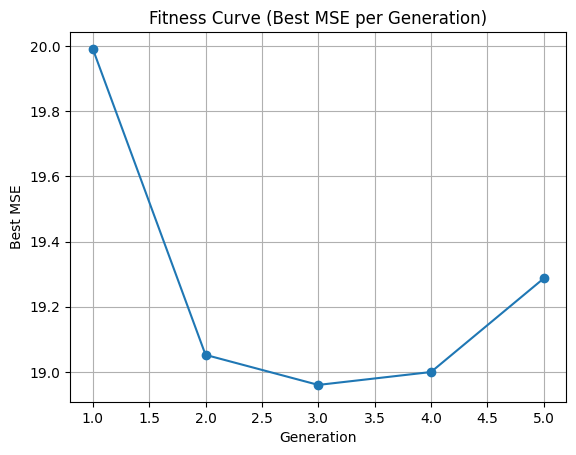

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(1, generations + 1), best_mse_per_generation, marker='o')
plt.title("Fitness Curve (Best MSE per Generation)")
plt.xlabel("Generation")
plt.ylabel("Best MSE")
plt.grid(True)
plt.show()


In [17]:
# === Final Model Training ===
best_units, best_dropout, best_batch, best_layers, best_lookback, best_lr = best_params
X = df[primary_features].apply(pd.to_numeric, errors='coerce').astype(float).values
Y = pd.to_numeric(df['FFF'], errors='coerce').astype(float).values
X_final, Y_final = create_lookback_sequences(X, Y, best_lookback)
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size=0.2, random_state=42)

final_model = create_bilstm_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                   units=best_units, dropout_rate=best_dropout,
                                   num_layers=best_layers, learning_rate=best_lr)
final_model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=best_batch,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)


# === Evaluation ===
Y_pred = final_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 32.5538 - mae: 4.8372 - val_loss: 21.5031 - val_mae: 3.7387
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 21.9341 - mae: 3.7451 - val_loss: 20.3383 - val_mae: 3.5977
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 20.3625 - mae: 3.5578 - val_loss: 19.0005 - val_mae: 3.4449
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 20.1855 - mae: 3.5214 - val_loss: 18.9504 - val_mae: 3.4511
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 19.4734 - mae: 3.4589 - val_loss: 18.4114 - val_mae: 3.4362
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 18.9343 - mae: 3.4088 - val_loss: 18.7373 - val_mae: 3.3818
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 18.9565 - mae: 3.4051 - val_loss: 18.2195 - val_mae: 3.3447
Epoch 8/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 19.3987 - mae: 3.4238 - val_loss: 18.4915 - val_mae: 3.3964
Epoch 9/50
254/254 ━━━━━━━━━━━━━━━━

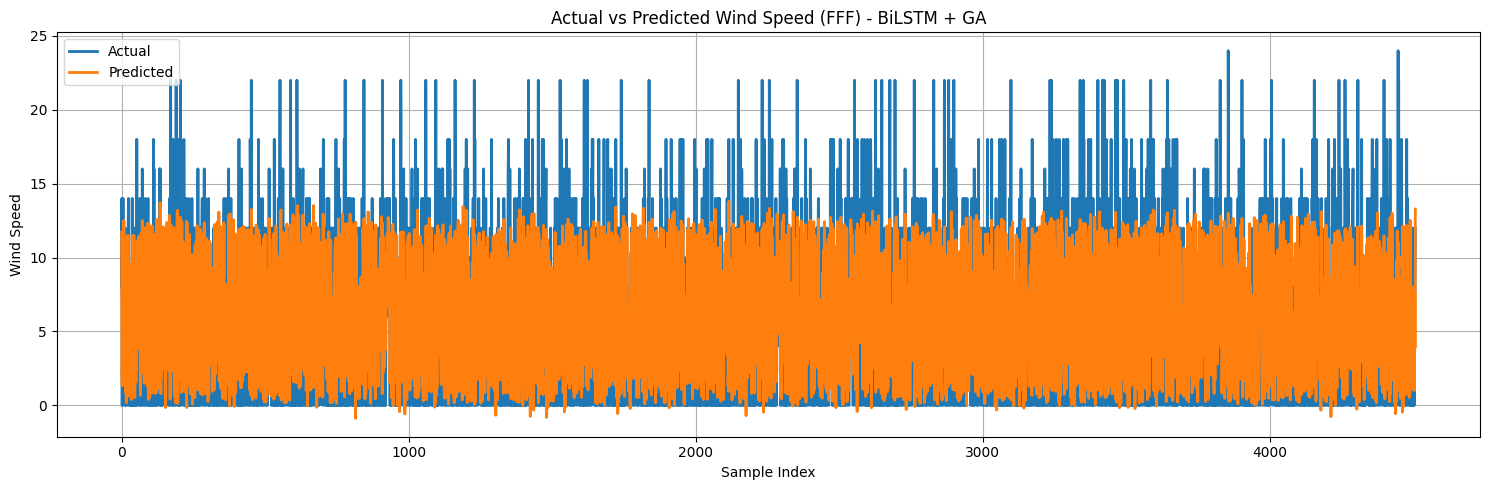

In [18]:
# === Plot ===
plt.figure(figsize=(15, 5))
plt.plot(Y_test, label='Actual', linewidth=2)
plt.plot(Y_pred, label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Wind Speed (FFF) - BiLSTM + GA")
plt.xlabel("Sample Index")
plt.ylabel("Wind Speed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


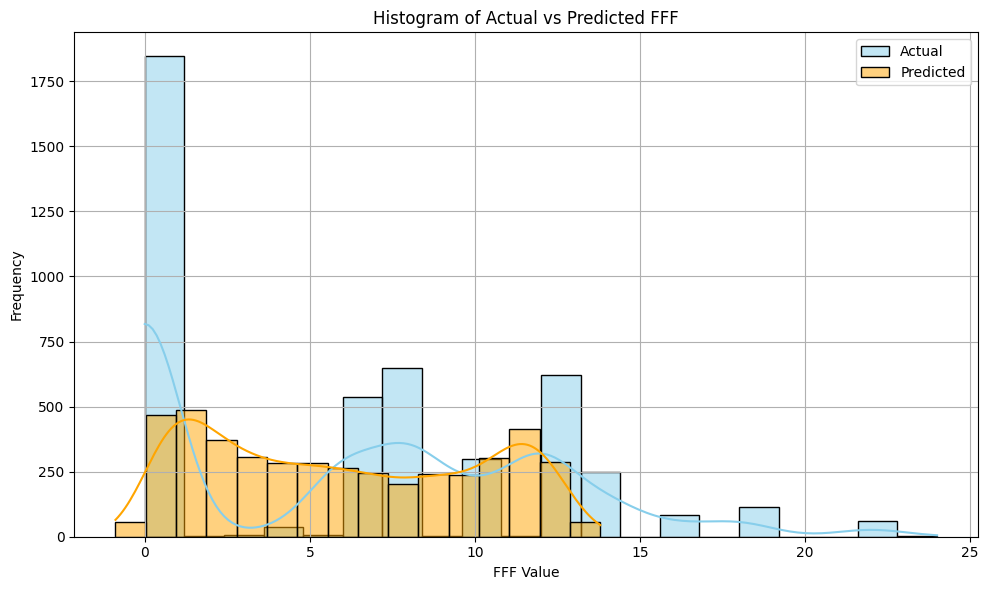

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Flatten values for plotting
y_true_flat = Y_test.flatten()
y_pred_flat = Y_pred.flatten()

# Create DataFrame for seaborn
df_hist = pd.DataFrame({
    'Actual': y_true_flat,
    'Predicted': y_pred_flat
})

plt.figure(figsize=(10, 6))
sns.histplot(df_hist['Actual'], color='skyblue', label='Actual', kde=True)
sns.histplot(df_hist['Predicted'], color='orange', label='Predicted', kde=True)
plt.title("Histogram of Actual vs Predicted FFF")
plt.xlabel("FFF Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


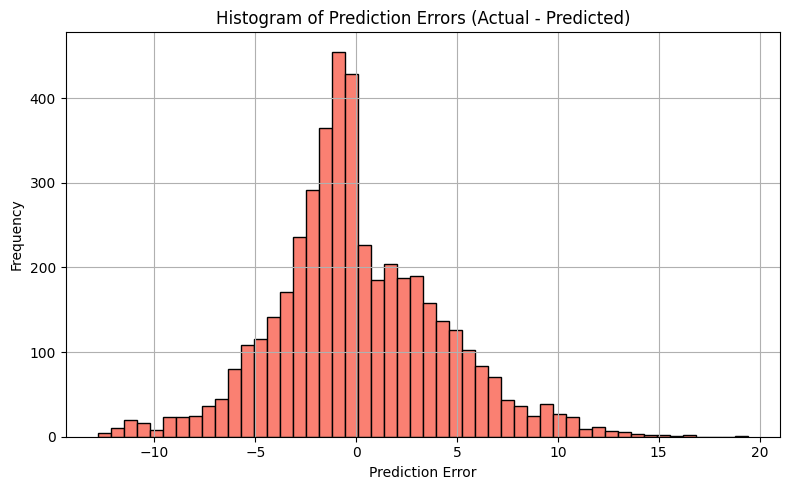

In [20]:
# Hsitogram Prediction Error
# Error = Actual - Predicted
error = y_true_flat - y_pred_flat

plt.figure(figsize=(8, 5))
plt.hist(error, bins=50, color='salmon', edgecolor='black')
plt.title("Histogram of Prediction Errors (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# === Save to CSV ===
import os
output_dir = "plot"
os.makedirs(output_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

result = {
    "Timestamp": timestamp,
    "Units": best_units,
    "Dropout": best_dropout,
    "Batch Size": best_batch,
    "Num Layers": best_layers,
    "Lookback": best_lookback,
    "Learning Rate": best_lr,
    "MAE": mae,
    "MSE": mse,
    "R2": r2
}

csv_path = os.path.join(output_dir, "Bi_GA.csv")

if os.path.exists(csv_path):
    df_existing = pd.read_csv(csv_path)
    df_existing = pd.concat([df_existing, pd.DataFrame([result])], ignore_index=True)
    df_existing.to_csv(csv_path, index=False)
else:
    pd.DataFrame([result]).to_csv(csv_path, index=False)

print(f"Results appended to CSV: {csv_path}")



Results appended to CSV: plot/Bi_GA.csv
